# Energy-preserving OpInf of Kuramoto-Sivashinky Equation 


In [1]:
using CSV
using DataFrames
using FFTW
using FileIO
using JLD2
using LaTeXStrings
using LinearAlgebra
using NaNStatistics
using Plots
using ProgressMeter
using Random
using SparseArrays

include("../src/model/KS.jl")
include("../src/LiftAndLearn.jl")
const LnL = LiftAndLearn
;


## Kuramoto-Sivashinsky (KS) Equation
The Kuramoto-Sivashinsky (KS) equation is a partial differential equation that describes the dynamics of certain spatiotemporal patterns in various physical systems, particularly in fluid dynamics and combustion processes. It was introduced by Yoshiki Kuramoto and Grigoriĭ Isaakovich Sivashinsky independently in the 1970s.

The equation is given by:

$$
\begin{gather*}
    u_t + uu_x + u_{xx} + \mu u_{xxxx} = 0,  \qquad x \in (-\infty, \infty) \\
    u(x,t) = u(x+L,t), \quad u_x(x,t) = u_x(x+L,t), \quad t \geq 0 
\end{gather*}
$$

where:
- $u(x, t)$ represents the spatially and temporally varying quantity being modeled (e.g., the amplitude of certain patterns in a fluid or combustion system).
- $t$ is time.
- $x$ is a spatial coordinate.

The terms in the equation have the following meanings:
- $u_t$: Represents the time rate of change of the quantity u.
- $uu_x$: Represents advection, describing how the quantity u is transported along the spatial coordinate x by its own gradient.
- $u_{xx}$: Represents diffusion, describing how the quantity u diffuses or spreads out over space.
- $u_{xxxx}$: Represents a fourth-order spatial derivative that accounts for certain nonlinear interactions and dispersion effects.
- $\mu$: Viscosity parameter.

The Kuramoto-Sivashinsky equation is known for producing a rich variety of complex spatiotemporal patterns, including traveling waves, oscillations, and turbulence-like behavior. It has applications in understanding and modeling various physical phenomena, such as the dynamics of flames, fluid interfaces, and certain chemical reactions. The equation's complexity and the diversity of patterns it can exhibit make it a subject of study in nonlinear dynamics and chaos theory.

For our analysis, we will construct a numerical model by descretizing the original PDE and separating the system into the linear and nonlinear components in the form of 

$$
\begin{gather*}
    \dot{\mathbf u} = \mathbf A \mathbf u + \mathbf F \mathbf u^{\langle 2\rangle}
\end{gather*}
$$

where $\mathbf A$, $\mathbf F$ are the linear and nonlinear operators respectively.


## Numerical Integration

Once we have the numerical model, we integrate it using the Adam-Bashforth and Crank-Nicolson Implicit scheme. The method is as follows.

$$
\begin{gather*}
    \dot{\mathbf u} = \mathbf A \mathbf u + \mathbf F \mathbf u^{\langle 2\rangle} \\
    \frac{\mathbf u^{k+1} - \mathbf u^k}{\Delta t} = \mathbf A \left(\frac{\mathbf u^{k+1} + \mathbf u^k}{2}\right) + \left[ \frac{3}{2}\mathbf F \left( \mathbf u^k \right)^{\langle 2\rangle} -\frac{1}{2}\mathbf F\left( u^{k-1} \right)^{\langle 2 \rangle } \right] 
\end{gather*}
$$

Hence 

$$
\begin{gather*}
    \mathbf u^{k+1} = 
    \begin{cases} 
        \left(\mathbf I - \frac{\Delta t}{2}\mathbf A \right)^{-1}\left[ \left( \mathbf I + \frac{\Delta t}{2}\mathbf A \right)\mathbf u^k + \Delta t\mathbf F \left( \mathbf u^k \right)^{\langle 2\rangle} \right] \qquad  k = 1 \\[0.3cm]
        \left(\mathbf I - \frac{\Delta t}{2}\mathbf A \right)^{-1}\left[ \left( \mathbf I + \frac{\Delta t}{2}\mathbf A \right)\mathbf u^k + \frac{3\Delta t}{2}\mathbf F \left( \mathbf u^k \right)^{\langle 2\rangle} -\frac{\Delta t}{2}\mathbf F\left( u^{k-1} \right)^{\langle 2 \rangle }\right] \qquad  k \geq 2
    \end{cases}
\end{gather*}
$$


## Numerical Model


In [2]:
# Settings for the KS equation
KSE = KS(
    [0.0, 1.0], [0.0, 1.0], [0.01, 0.1],
    2^(-7), 1e-4, 1
)
;


### Finite Difference Approach

Similar to the discretization of the [1D Heat equation](01_heat1D_OpInf_LS.ipynb), [1D Burgers' equation](02_burgers_OpInf_LS.ipynb), and [Fitzhugh-Nagumo equation](03_fhn_LnL_LS.ipynb) we discretize the PDE using finite difference approach. In order to discretize in the spatial and temporal domains we definte the grid size $\Delta x$ and time-step $\Delta t$. Furthermore, let the subscript and superscript indicate the spatial and temporal indices respectively, i.e., $u_{i}^k$. Then we show how we discretize each term below.

$$
\begin{align*}
    u_{xxxx} &\approx \frac{1}{\Delta x^4} \left( u_{i+2} - 4u_{i+1} + 6u_i - 4u_{i-1} + u_{i-2} \right) \\
    u_{xx} &\approx \frac{1}{\Delta x^2} \left( u_{i+1} - 2u_i + u_{i-1} \right) \\
    u_x &\approx \frac{1}{2\Delta x} \left( u_{i+1} - u_{i-1} \right) \quad .
\end{align*}
$$

Then we can represent the KS equation model with distinct linear and nonlinear terms

$$
\begin{gather*}
    \dot u_i = \underbrace{ \left[ -\frac{\mu}{\Delta x^4} (u_{i+2} + u_{i-2}) + \left( \frac{4\mu}{\Delta x^4}-\frac{1}{\Delta x^2} \right)(u_{i+1} + u_{i-1}) + \left( \frac{2}{\Delta x^2}-\frac{6\mu}{\Delta x^4} \right)u_i \right] }_{\text{linear}}
    + \underbrace{\frac{1}{2\Delta x}\left( u_iu_{i-1} - u_iu_{i+1} \right)}_{\text{nonlinear}}
\end{gather*}
$$

Thus, assuming we have periodic boundary conditions, we can represent the KS equation as a linear-quadratic ODE with respect to time by expanding the above expression to all of the spatial grid:

$$
\begin{gather*}
    \mathbf{\dot u}(t) = \mathbf{A}\mathbf u(t) + \mathbf{F} \mathbf u^{\langle 2 \rangle}(t)
\end{gather*}
$$

where $\mathbf A \in \mathbb R^{N\times N}$ is the linear operator, $\mathbf F \in \mathbb R^{N \times N(N+1)/2}$ is the quadratic operator, and  $\mathbf u^{\langle 2\rangle} \in \mathbb R^{N(N+1)/2}$ represents the quadratic states with no redundancy. The matrix $\mathbf A$ would be a toeplitz matrix (except for the periodic terms) and the $\mathbf F$ would be a sparse matrix.


In [3]:
L = KSE.Omega[2]
u0 = cos.((2*π*KSE.x)/L) + 0.1*cos.((4*π*KSE.x)/L)  # initial condition

# Generate the operators
A, F = KSE.model_FD(KSE, KSE.μs[1])
;

In [4]:
# Integrate
u = KSE.integrator(A, F, KSE.t, u0)
;

In [ ]:
plot(contour(KSE.t, KSE.x, u, fill=true), xlabel=L"t, \mathrm{time}",
    ylabel=L"ω, \mathrm{space}", zlabel=L"u(x,t)", title=L"\mathrm{Training~Data}", size=(680, 400))
plot!(guidefontsize=16, tickfontsize=8,  legendfontsize=13)

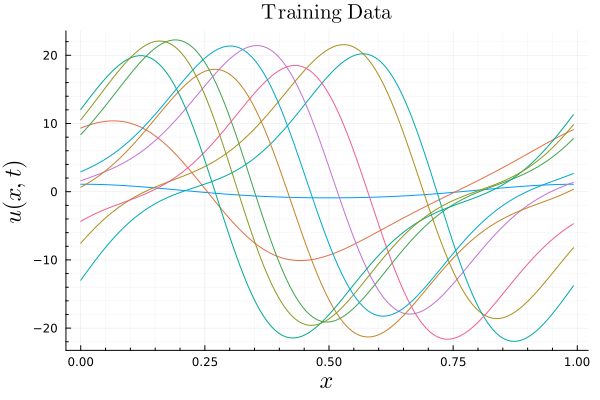

In [6]:
p1 = plot()
for i in 1:1000:KSE.Tdim
    plot!(p1, KSE.x, u[:, i])
end
plot!(p1, xlabel=L"x", ylabel=L"u(x,t)", title=L"\mathrm{Training~Data}", grid=true,
    minorgrid=true, legend=false)
plot!(guidefontsize=16, tickfontsize=8,  legendfontsize=13)



### Fourier Transformation Approach

We consider a periodic domain $[0,L]$ for the solution of the Kuramoto-Sivashinsky equation. Our periodic grid has $N$ points $\{x_n\}_{n=1}^N$, where $x_n = n\Delta x$ and $\Delta x = L/N$. With $N$ degrees of freedom we can write the solution $u(x,t)$ as a truncated Fourier expansion with $N$ modes:
$$
\begin{align*}
u(x,t) = \int_{-\infty}^\infty \hat u_k(t)\exp\left(\frac{2\pi j kx}{L}\right)dk \approx \sum_{k=-N/2}^{N/2-1}\hat{u}_k(t)\exp\left(\frac{2\pi jkx}{L}\right).
\end{align*}
$$

Now from here, we introduce two possible methods using the Fourier transform. The first method, uses the Fast Fourier Transform (FFT) to deal with the nonlinear term. In contrast, the second method uses some change of index techniques and extracts the real part of the Fourier transform.

#### Method 1

We begin by plugging the approximate Fourier transform of $u(x,t)$ back into the original PDE which give us 

$$
\begin{align*}
    \dot u(x,t) &\approx \sum_{k=-N/2}^{N/2-1} \dot{\hat u_k}(t)\exp\left( \frac{2\pi jkx}{L} \right) \\
    \mu u_{xxxx} + u_{xx} &\approx  \sum_{k=-N/2}^{N/2-1}\mu\left( \frac{2\pi j k}{L} \right)^4 \hat u_k(t) \exp\left( \frac{2\pi j k x}{L} \right) + \sum_{k=-N/2}^{N/2-1}\left( \frac{2\pi j k}{L} \right)^2  \hat u_k(t) \exp\left( \frac{2\pi j kx}{L} \right) = -\sum_{k=-N/2}^{N/2-1} \left[ \left( \frac{2\pi k}{L} \right)^2 - \mu\left( \frac{2\pi  k}{L} \right)^4 \right] \hat u_k(t) \exp\left( \frac{2\pi j kx}{L} \right) \\
    uu_x &= \frac{1}{2}\left( u^2 \right)_x \approx \frac{1}{2} \frac{2\pi j k}{L}\left( \hat u^2 \right)_k = \frac{1}{2} \frac{2\pi j k }{L} ~\mathrm{FFT}\left[ u^2(t) \right]
\end{align*}
$$

Then if we collect the terms within the summation and multiplied by $\exp(2\pi jk x/L )$ we have

$$
\begin{gather*}
    \dot{\hat u}_k(t) = \underbrace{\left[ \left( \frac{2\pi k}{L}\right)^2 - \mu\left( \frac{2\pi k}{L} \right)^4 \right]\hat u_k(t)}_{\text{linear}} - \underbrace{\frac{\pi j k}{L}~\mathrm{FFT}\left[ u^2(t) \right]}_{\text{nonlinear}}
\end{gather*}
$$

For more detail on the derivation, refer to [this paper](http://pubs.sciepub.com/ajna/2/3/5/abstract.html) by Gentian Zavalani. If write this in the form of $\mathbf{\dot u}(t) = \mathbf{A}\mathbf u(t) + \mathbf{F} \mathbf u^{\langle 2 \rangle}(t)$ we will have a diagonal matrix of $\mathbf A$ and a full matrix for $\mathbf F$ where the square quadratic terms (e.g., $u_6^2$) have a factor of 1 and the non-square quadratic terms (e.g., $u_5u_6$) have a factor of 2 since they would have a redundant/symmetric term.  The original states $u(t)$ of the KS equation can be retained by performing the inverse FFT (iFFT) on the states $\hat u(t)$.



In [3]:
L = KSE.Omega[2]
u0 = cos.((2*π*KSE.x)/L) + 0.1*cos.((4*π*KSE.x)/L)  # initial condition

# Generate the operators
A, F = KSE.model_FFT(KSE, KSE.μs[1])
;

In [4]:
# Integrate
u, uhat = KSE.integrator_fourier(A, F, KSE.t, u0)
;

DimensionMismatch: DimensionMismatch: 

In [ ]:
plot(contour(KSE.t, KSE.x, u, fill=true), xlabel=L"t, \mathrm{time}",
    ylabel=L"ω, \mathrm{space}", zlabel=L"u(x,t)", title=L"\mathrm{Training~Data}", size=(680, 400))
plot!(guidefontsize=16, tickfontsize=8,  legendfontsize=13)

In [ ]:
p1 = plot()
for i in 1:1000:KSE.Tdim
    plot!(p1, KSE.x, u[:, i])
end
plot!(p1, xlabel=L"x", ylabel=L"u(x,t)", title=L"\mathrm{Training~Data}", grid=true,
    minorgrid=true, legend=false)
plot!(guidefontsize=16, tickfontsize=8,  legendfontsize=13)


#### Method 2

For the second method, the first half is the same as the first one where we plug the Fourier transform into the original PDE. However, we take a different route for the nonlinear term. Specifically, we manipulate the nonlinear term after plugging in the Fourier transform in the following manner:

$$
\begin{align*}
    uu_x &= \frac{1}{2}\left( u^2 \right)_x \approx \frac{1}{2} \left[ \left( \sum_{k=-N/2}^{N/2-1} \hat u_k(t) \exp\left( \frac{2\pi jkx}{L} \right) \right) \left( \sum_{k=-N/2}^{N/2-1} \hat u_k(t) \exp\left( \frac{2\pi jkx}{L} \right) \right)\right]_x \\
    &= \frac{1}{2} \left[ \left( \sum_{k,l=-N/2}^{N/2-1} \hat u_k(t) \hat u_l(t) \exp\left( \frac{2\pi j(k+l)x}{L} \right) \right) \right]_x \\
    &= \frac{1}{2}\left( \sum_{k,l=-N/2}^{N/2-1} \frac{2\pi j(k+l)}{L} \hat u_k(t) \hat u_l(t) \exp\left( \frac{2\pi j(k+l)x}{L} \right) \right)
\end{align*}
$$

Let $k = m$ and $l = k - m$, then

$$
\begin{align*}
    uu_x &\approx \frac{\pi jk}{L}\left( \sum_{m,k-m=-N/2}^{N/2-1}  \hat u_m(t) \hat u_{k-m}(t) \exp\left( \frac{2\pi jkx}{L} \right) \right)
\end{align*}
$$

Thus, in Fourier space, by collecting the terms inside the summation and multiplied by the exponential term we have

$$
\begin{gather*}
    \dot{\hat u}_k(t) = \underbrace{\left[ \left( \frac{2\pi k}{L}\right)^2 - \mu\left( \frac{2\pi k}{L} \right)^4 \right]\hat u_k(t)}_{\text{linear}} - \underbrace{\frac{\pi jk}{L} \sum_{m=-N/2}^{N/2-1}  \hat u_m(t) \hat u_{k-m}(t)}_{\text{nonlinear}} \quad .
\end{gather*}
$$

Assume $\hat u_k$ is pure imaginary (which is unlikely). Then let us define  $\hat u_k(t) = j\hat v_k(t)$, where $v_k(t) \in \mathbb R^N$, to limit the model in the real space, which brings us to

$$
\begin{gather*}
    \dot{\hat v}_k(t) = \underbrace{\left[ \left( \frac{2\pi k}{L}\right)^2 - \mu\left( \frac{2\pi k}{L} \right)^4 \right]\hat v_k(t)}_{\text{linear}} + \underbrace{\frac{\pi k}{L} \sum_{m=-N/2}^{N/2-1}  \hat v_m(t) \hat v_{k-m}(t)}_{\text{nonlinear}} \quad .
\end{gather*}
$$

Thus, in the real Fourier space, the model can be expressed as 

$$
\begin{gather*}
    \dot{\hat{\mathbf{v}}}(t) = \mathbf{A}\hat{\mathbf v}(t) + \mathbf{F} \hat{\mathbf v}^{\langle 2 \rangle}(t) \quad .
\end{gather*}
$$

Now, since the Fourier transform $\mathcal F$ is a linear operator, so is the inverse Fourier transform $\mathcal F^{-1}$. Hence, the KS model in the time domain is expressed as 

$$
\begin{gather*}
    \mathcal F^{-1}\left[ \dot{\hat{\mathbf{v}}}(t) \right] = \mathbf{A}~\mathcal F^{-1} \left[\hat{\mathbf v}(t)\right] + \mathbf{F} ~\mathcal F^{-1}\left[\hat{\mathbf v}^{\langle 2 \rangle}(t) \right] \quad .
\end{gather*}
$$

where the linear and quadratic operators do not change. For more details consult [this paper](https://dx.doi.org/10.1088/0951-7715/10/1/004). 

However we would NOT want to assume $\hat u_k$ to be pure imaginary so we will just let 

$$
\begin{gather*}
    \dot{\hat{\mathbf{u}}}(t) = \mathbf{A}\hat{\mathbf u}(t) + \mathbf{F} \hat{\mathbf u}^{\langle 2 \rangle}(t) \quad ,
\end{gather*}
$$

where $\mathbf F$ would have complex valued entries. To acquire the original states $u(t)$ of the KS equation we will have to perform the inverse FFT (iFFT) on the state data in the Fourier space.
